In [1]:
# Imports
from fastapi import FastAPI
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import uvicorn
import shap
import dill
from io import StringIO

import fonctions_python as fc

# Paramètres d'affichage :
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

# Create a FastAPI instance
app = FastAPI(
    title="Projet n°7",
    version="1.0.0",
    description="Implémentez un modèle de scoring."
)

# Répertoires
path_dir = "./"

# Loading the model
model_final = fc.load_joblib("model_final.joblib", path_dir)

# Loading the datas
# with open(path_dir + path_datas_save + 'dict_agg.pkl', 'rb') as file:
#     dict_agg = dill.load(file)

# X_train = dict_agg['X_train']
# y_train = dict_agg['y_train']
# X_test = dict_agg['X_test']

X_train = pd.read_csv(path_dir + 'df_datas_train_reduit_cleaned.csv')
X_test = pd.read_csv(path_dir + 'df_datas_test_reduit_cleaned.csv')

cols = X_train.select_dtypes(['float64']).columns
X_train_scaled = X_train.copy()
X_train_scaled[cols] = StandardScaler().fit_transform(X_train[cols])

cols = X_test.select_dtypes(['float64']).columns
X_test_scaled = X_test.copy()
X_test_scaled[cols] = StandardScaler().fit_transform(X_test[cols])

tree_explainer = shap.TreeExplainer(model_final['classifier'], approximate=True)


# Functions
def welcome():
    """
    Welcome message.
    :param: None
    :return: Message (string).
    """
    return 'Bienvenue sur le projet Openclassrooms n°7 : Implémentez un modèle de scoring'


def test_user(user_id: int):
    return {"user_id": user_id}


def check_client_id(client_id: int) -> bool:
    """
    Customer search in the database
    :param: client_id (int)
    :return: message (string).
    """
    if client_id in list(X_test['SK_ID_CURR']):
        return True
    else:
        return False


def get_client(client_id: int):
    """
    Give data client.
    :param: client_id (int)
    :return: datas of the client.
    """
    client_data = X_test[X_test['SK_ID_CURR'] == client_id]
    return client_data.to_json()


def get_prediction(client_id: int):
    """
    Calculates the probability of default for a client.
    :param: client_id (int)
    :return: probability of default (float).
    """
    client_data = X_test[X_test['SK_ID_CURR'] == client_id]
    client_data = client_data.drop('SK_ID_CURR', axis=1)
    prediction = model_final.predict_proba(client_data)[0][1]
    return prediction


def get_data_voisins(client_id: int):
    """ Calcul les plus proches voisins du client_id et retourne le dataframe de ces derniers.
    :param: client_id (int)
    :return: dataframe de clients similaires (json).
    """
    features = list(X_test_scaled.columns)
    features.remove('SK_ID_CURR')

    # Création d'une instance de NearestNeighbors
    nn = NearestNeighbors(n_neighbors=10, metric='euclidean')

    # Entraînement du modèle sur les données
    nn.fit(X_train_scaled[features])
    reference_id = client_id
    reference_observation = X_test_scaled[X_test_scaled['SK_ID_CURR'] == reference_id][features].values
    indices = nn.kneighbors(reference_observation, return_distance=False)
    df_voisins = X_train.iloc[indices[0], :]

    return df_voisins.to_json()


def shap_values_local(client_id: int) -> dict:
    """ Calcul les shap values pour un client.
        :param: client_id (int)
        :return: shap values du client (json).
        """
    client_data = X_test_scaled[X_test_scaled['SK_ID_CURR'] == client_id]
    client_data = client_data.drop('SK_ID_CURR', axis=1)
    shap_val = tree_explainer(client_data)[0]
    return {
        'shap_values': shap_val.values.tolist(),
        'base_value': shap_val.base_values,
        'data': client_data.values.tolist(),
        'feature_names': client_data.columns.tolist()
    }


def shap_values() -> dict:
    """ Calcul les shap values de l'ensemble du jeu de données
    :param:
    :return: shap values
    """
    shap_val = tree_explainer.shap_values(X_test_scaled.drop('SK_ID_CURR', axis=1))
    return {
        'shap_values_0': shap_val[0].tolist(),
        'shap_values_1': shap_val[1].tolist()
    }

In [2]:
X_train.head()

,SK_ID_CURR,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_DAYS_CREDIT_MIN,DAYS_EMPLOYED,REGION_RATING_CLIENT,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,DAYS_EMPLOYED_PERC,DAYS_LAST_PHONE_CHANGE,CODE_GENDER,NAME_EDUCATION_TYPE,BURO_DAYS_CREDIT_MAX,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,CLOSED_DAYS_CREDIT_MAX,BURO_CREDIT_ACTIVE_Active_MEAN,NAME_INCOME_TYPE,FLAG_EMP_PHONE,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,ACTIVE_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_VAR,DAYS_REGISTRATION,CLOSED_DAYS_CREDIT_VAR,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_DAYS_DECISION_MIN,OCCUPATION_TYPE,HOUSETYPE_MODE_blockofflats,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_TYPE_SUITE,ORGANIZATION_TYPE,FLAG_OWN_REALTY,FLAG_OWN_CAR
0,391369,0.385400,0.367291,66.594521,0.777778,0.333333,778.0,1648.0,3,0.111111,0.118733,418.0,1,5.0,163.0,2165.0,0,163.0,0.666667,4.0,0,0,0,166.0,125463.000000,173.0,0.000000,0.222222,916.0,0.0,0,0,0,48600.0,76410.0,5233.5,67500.0,6.0,2.0,7.0,58.0,0,0
1,131710,0.608885,0.501075,28.057534,0.000000,0.777778,1397.0,1767.0,2,0.000000,0.172542,1074.0,0,2.0,314.0,2905.0,0,314.0,0.222222,8.0,1,0,1,617.0,149696.250000,5154.0,140123.238095,1.000000,1074.0,0.0,0,0,0,180000.0,341280.0,24961.5,270000.0,2.0,2.0,13.0,43.0,0,1
2,248985,0.025221,0.497469,59.336986,0.000000,0.750000,1431.0,1648.0,2,0.000000,0.118733,1298.0,1,5.0,111.0,4533.0,0,277.0,0.250000,4.0,0,0,1,111.0,251804.285714,8061.0,270394.266667,1.000000,2573.0,0.0,1,0,0,67500.0,112500.0,11947.5,112500.0,2.0,2.0,7.0,58.0,0,0
3,291263,0.659627,0.294083,22.635616,0.000000,0.000000,67.0,171.0,2,0.000000,0.020697,845.0,0,5.0,67.0,927.0,1,0.0,1.000000,2.0,1,1,1,67.0,0.000000,2531.0,0.000000,0.750000,845.0,0.0,0,0,0,184500.0,204768.0,14967.0,162000.0,1.0,6.0,7.0,6.0,1,0
4,233182,0.466877,0.716570,45.991781,0.000000,0.375000,2294.0,6760.0,3,0.000000,0.402693,775.0,1,2.0,161.0,331.0,0,904.0,0.625000,2.0,1,0,1,161.0,403509.714286,8904.0,643570.333333,1.000000,2276.0,0.0,1,0,0,247500.0,1237500.0,36184.5,1237500.0,2.0,2.0,7.0,42.0,1,0


In [3]:
X_train.shape

(30750, 43)

In [4]:
X_test.head()

,SK_ID_CURR,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_DAYS_CREDIT_MIN,DAYS_EMPLOYED,REGION_RATING_CLIENT,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,DAYS_EMPLOYED_PERC,DAYS_LAST_PHONE_CHANGE,CODE_GENDER,NAME_EDUCATION_TYPE,BURO_DAYS_CREDIT_MAX,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,CLOSED_DAYS_CREDIT_MAX,BURO_CREDIT_ACTIVE_Active_MEAN,NAME_INCOME_TYPE,FLAG_EMP_PHONE,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,ACTIVE_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_VAR,DAYS_REGISTRATION,CLOSED_DAYS_CREDIT_VAR,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_DAYS_DECISION_MIN,OCCUPATION_TYPE,HOUSETYPE_MODE_blockofflats,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_TYPE_SUITE,ORGANIZATION_TYPE,FLAG_OWN_REALTY,FLAG_OWN_CAR
0,186426,0.317328,0.181959,25.871233,0.00,0.727273,668.0,2399.0,2,0.000000,0.254051,281.0,0,3.0,30.0,1172.0,0,56.0,0.272727,2.0,1,0,1,30.0,46390.818182,3774.0,9747.267857,1.000000,281.0,9.0,1,0,225000.0,270000.0,21460.5,270000.0,4.0,6.0,14.0,5.0,0,1
1,239207,0.709575,0.244516,60.460274,0.00,0.250000,802.0,1765.0,2,0.000000,0.128206,-0.0,1,5.0,354.0,4196.0,0,802.0,0.750000,4.0,0,0,1,354.0,36763.333333,3438.0,0.000000,0.666667,958.0,0.0,1,0,67500.0,144801.0,10953.0,117000.0,4.0,2.0,7.0,58.0,0,0
2,243371,0.672684,0.340906,34.920548,0.00,0.750000,1457.0,1577.0,1,0.000000,0.123725,490.0,0,5.0,675.0,4572.0,1,675.0,0.250000,8.0,1,0,1,1457.0,145766.666667,849.0,81844.000000,1.000000,490.0,7.0,0,2,270000.0,846000.0,54198.0,846000.0,2.0,2.0,7.0,8.0,0,0
3,156405,0.748743,0.438281,27.561644,0.00,0.500000,1423.0,1730.0,3,0.000000,0.171968,1886.0,1,2.0,251.0,2729.0,1,371.0,0.500000,8.0,1,1,1,251.0,171215.727273,4206.0,152450.966667,1.000000,1000.0,1.0,0,0,225000.0,334152.0,17190.0,270000.0,4.0,2.0,14.0,52.0,0,0
4,412720,0.687765,0.241861,42.857534,0.25,0.571429,2821.0,791.0,2,0.166667,0.050566,1014.0,1,3.0,65.0,4940.0,1,1167.0,0.428571,8.0,1,1,1,65.0,987357.302198,7507.0,403059.642857,0.666667,2772.0,1.0,0,0,234000.0,675000.0,49117.5,675000.0,2.0,2.0,7.0,56.0,0,0


In [5]:
X_test.shape

(4874, 42)

In [6]:
welcome()

'Bienvenue sur le projet Openclassrooms n°7 : Implémentez un modèle de scoring'

In [7]:
test_user(239207)

{'user_id': 239207}

In [8]:
check_client_id(239207)

True

In [9]:
df_data_client_json = get_client(239207)
df_data_client = pd.read_json(StringIO(df_data_client_json))
df_data_client.head()

,SK_ID_CURR,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_DAYS_CREDIT_MIN,DAYS_EMPLOYED,REGION_RATING_CLIENT,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,DAYS_EMPLOYED_PERC,DAYS_LAST_PHONE_CHANGE,CODE_GENDER,NAME_EDUCATION_TYPE,BURO_DAYS_CREDIT_MAX,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,CLOSED_DAYS_CREDIT_MAX,BURO_CREDIT_ACTIVE_Active_MEAN,NAME_INCOME_TYPE,FLAG_EMP_PHONE,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,ACTIVE_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_VAR,DAYS_REGISTRATION,CLOSED_DAYS_CREDIT_VAR,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_DAYS_DECISION_MIN,OCCUPATION_TYPE,HOUSETYPE_MODE_blockofflats,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_TYPE_SUITE,ORGANIZATION_TYPE,FLAG_OWN_REALTY,FLAG_OWN_CAR
1,239207,0.709575,0.244516,60.460274,0,0.25,802,1765,2,0,0.128206,0,1,5,354,4196,0,802,0.75,4,0,0,1,354,36763.333333,3438,0,0.666667,958,0,1,0,67500,144801,10953,117000,4,2,7,58,0,0


In [10]:
get_prediction(239207)

0.4065950753762972

In [11]:
get_prediction(412720)

0.5419347234890807

In [12]:
df_data_voisins_json = get_data_voisins(239207)
df_data_voisins = pd.read_json(StringIO(df_data_voisins_json))
df_data_voisins.head()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,SK_ID_CURR,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_DAYS_CREDIT_MIN,DAYS_EMPLOYED,REGION_RATING_CLIENT,PREV_NAME_PRODUCT_TYPE_walkin_MEAN,DAYS_EMPLOYED_PERC,DAYS_LAST_PHONE_CHANGE,CODE_GENDER,NAME_EDUCATION_TYPE,BURO_DAYS_CREDIT_MAX,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,CLOSED_DAYS_CREDIT_MAX,BURO_CREDIT_ACTIVE_Active_MEAN,NAME_INCOME_TYPE,FLAG_EMP_PHONE,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,ACTIVE_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_VAR,DAYS_REGISTRATION,CLOSED_DAYS_CREDIT_VAR,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_DAYS_DECISION_MIN,OCCUPATION_TYPE,HOUSETYPE_MODE_blockofflats,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_TYPE_SUITE,ORGANIZATION_TYPE,FLAG_OWN_REALTY,FLAG_OWN_CAR
24955,258825,0.743070,0.315472,67.813699,0.0,0.250000,1276,1648,3,0,0.118733,434,1,5,228,3996,0,1276,0.750000,4,0,0,1,228,201796.000000,728,0.000000,0.800000,434,0,1,0,0,135000,239850,23494.5,225000,6,2,7,58,0,0
19606,222103,0.623237,0.309275,61.665753,0.0,0.571429,1154,1648,2,0,0.118733,94,1,5,53,5042,0,240,0.428571,4,0,0,0,53,164043.238095,1477,161572.916667,1.000000,1483,0,0,0,0,103500,225000,11250.0,225000,4,2,7,58,0,0
28857,446242,0.589573,0.572683,60.786301,0.0,0.333333,480,1648,3,0,0.118733,824,1,5,333,4706,0,480,0.666667,4,0,0,1,333,6704.333333,893,0.000000,0.500000,824,0,0,0,0,85500,153000,7569.0,153000,3,2,7,58,0,0
9475,163668,0.660206,0.497469,64.772603,0.0,0.500000,1599,1648,2,0,0.118733,580,1,5,265,4184,0,590,0.500000,4,0,0,1,265,263128.488889,258,241530.300000,0.666667,895,0,1,0,0,90000,227493,17136.0,207000,2,2,7,58,0,0
14917,450368,0.670702,0.420611,60.556164,0.0,0.000000,295,1648,2,0,0.118733,962,1,5,295,4066,0,0,1.000000,4,0,0,1,295,0.000000,5879,0.000000,1.000000,962,0,1,0,0,63000,207306,9261.0,148500,2,2,9,58,0,0


In [13]:
shap_val = shap_values_local(239207)

In [14]:
shap_val_local = shap_val['shap_values']
base_value = shap_val['base_value']
feat_values = shap_val['data']
feat_names = shap_val['feature_names']

explanation = shap.Explanation(
    np.reshape(np.array(shap_val_local, dtype='float'), (1, -1)),
    base_value,
    data=np.reshape(np.array(feat_values, dtype='float'), (1, -1)),
    feature_names=feat_names
)

expl = explanation[0]

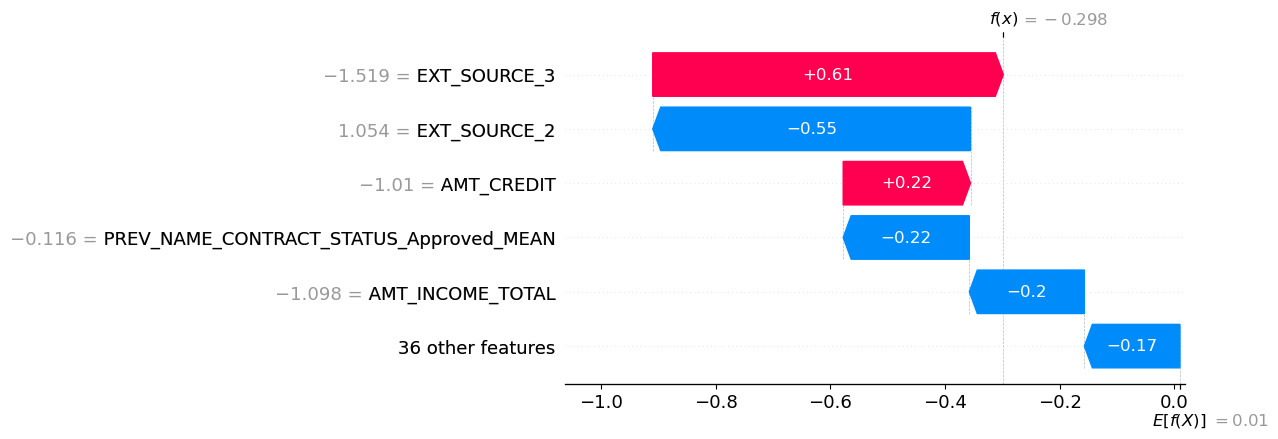

In [15]:
shap.waterfall_plot(expl, max_display=6, show=True)

In [16]:
shap_values_target = shap_values()
shap_val_glob_0 = shap_values_target['shap_values_0']
shap_val_glob_1 = shap_values_target['shap_values_1']
shap_globales = np.array([shap_val_glob_0, shap_val_glob_1])
shap_globales

C:\Users\jme1401\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


array([[ 0.32222147,  0.71256608, -0.39321664, -0.05303991, -0.09427491,
         0.01865461, -0.02992634,  0.00261411, -0.01116268, -0.01336895,
        -0.19066352, -0.0027416 ,  0.05239172, -0.08383528, -0.01090637,
        -0.03940849,  0.03788354, -0.01112274,  0.10445921, -0.05914336,
        -0.01593932,  0.00374201, -0.0247961 ,  0.50139306, -0.14131394,
        -0.0205817 , -0.26431908,  0.1481631 ,  0.03762002,  0.02467332,
        -0.05077628, -0.17721029,  0.14243784,  0.        ,  0.06907967,
         0.04676358,  0.04686308, -0.0243365 , -0.02142605,  0.00371752,
        -0.14352843],
       [-0.5542823 ,  0.61153215, -0.04746431, -0.04663174,  0.07259772,
         0.01276125, -0.02377654,  0.09636955, -0.00985988, -0.00755364,
        -0.14004813,  0.00211002,  0.00477942,  0.00660419,  0.01507848,
        -0.02868901, -0.06348218, -0.01626707,  0.00940761, -0.03515532,
        -0.00532007,  0.00464562,  0.00620821,  0.11808419, -0.1183053 ,
        -0.01990029, -0.22000

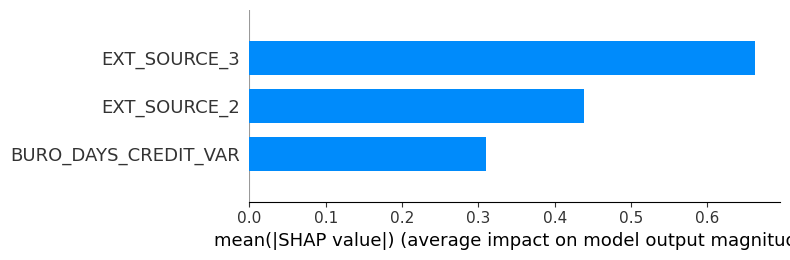

In [17]:
shap.summary_plot(shap_globales, X_test_scaled.drop('SK_ID_CURR', axis=1), plot_type='bar', max_display=3)
        